In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
import cv2
import math
import os
import imageio
from PIL import Image,ImageOps

from skimage import measure
from skimage.transform import resize, rescale
from skimage import img_as_ubyte

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

In [ ]:
from parameters import Div2kParameters
from gen import build_generator
from pretrained import pretrained_models
from predictions import get_sr_image
from config import config
from disc import build_discriminator
from data_loader import create_training_dataset, create_training_and_validation_datasets, create_validation_dataset
from data_mapping import random_crop, random_flip, random_rotate, random_lr_jpeg_noise

In [ ]:
dataset_key = "bicubic_x4"

data_path = config.get("data_path", "")

div2k_folder = os.path.abspath(os.path.join(data_path, "div2k"))

dataset_parameters = Div2kParameters(dataset_key, save_data_directory=div2k_folder)

In [ ]:
def load_image(path):
    img = Image.open(path)

    was_grayscale = len(img.getbands()) == 1

    if was_grayscale or len(img.getbands()) == 4:
        img = img.convert('RGB')

    return was_grayscale, np.array(img)

In [ ]:
hr_crop_size = 96

In [ ]:
train_mappings = [
    lambda lr, hr: random_crop(lr, hr, hr_crop_size=hr_crop_size, scale=dataset_parameters.scale),
    random_flip,
    random_rotate,
    random_lr_jpeg_noise]

In [ ]:
train_dataset, valid_dataset = create_training_and_validation_datasets(dataset_parameters, train_mappings)

valid_dataset_subset = valid_dataset.take(10)

In [ ]:
generator = build_generator(scale=dataset_parameters.scale)

In [ ]:
checkpoint_dir=f'/content/drive/MyDrive/SRGAN/ckpt/sr_resnet_{dataset_key}'

learning_rate=1e-4

checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                 epoch=tf.Variable(0),
                                 psnr=tf.Variable(0.0),
                                 optimizer=Adam(learning_rate),
                                 model=generator)

checkpoint_manager = tf.train.CheckpointManager(checkpoint=checkpoint,
                                                directory=checkpoint_dir,
                                                max_to_keep=3)

if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(f'Model restored from checkpoint at step {checkpoint.step.numpy()} with validation PSNR {checkpoint.psnr.numpy()}.')

Model restored from checkpoint at step 1000000 with validation PSNR 0.0.


In [ ]:
training_steps = 1_000_000

steps_per_epoch = 1000

training_epochs = training_steps / steps_per_epoch

if checkpoint.epoch.numpy() < training_epochs:
    remaining_epochs = int(training_epochs - checkpoint.epoch.numpy())
    print(f"Continuing Training from epoch {checkpoint.epoch.numpy()}. Remaining epochs: {remaining_epochs}.")
    save_checkpoint_callback = SaveCustomCheckpoint(checkpoint_manager, steps_per_epoch)
    checkpoint.model.compile(optimizer=checkpoint.optimizer, loss=MeanSquaredError(), metrics=[psnr_metric])
    history = checkpoint.model.fit(train_dataset,validation_data=valid_dataset_subset, steps_per_epoch=steps_per_epoch, epochs=remaining_epochs, callbacks=[save_checkpoint_callback])
else:
    print("Training already completed. To continue training, increase the number of training steps")


Training already completed. To continue training, increase the number of training steps


In [ ]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="training loss")
plt.plot(epochs,val_loss,'r',label="validation loss")
plt.title("training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig("/content/drive/MyDrive/SRGAN/Results/training_and_validation_loss.png")
plt.show()

In [ ]:
acc=history.history["psnr_metric"]
val_acc=history.history["val_psnr_metric"]
epochs=range(1,len(loss)+1)
plt.plot(epochs,acc,'y',label="training acc")
plt.plot(epochs,val_acc,'r',label="validation acc")
plt.title("training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.savefig("/content/drive/MyDrive/SRGAN/Results/training_and_validation_acc.png")
plt.show()

In [ ]:
weights_directory = f"/content/drive/MyDrive/SRGAN/weights/{dataset_key}"
os.makedirs(weights_directory, exist_ok=True)
weights_file = f'{weights_directory}/generator.h5'
checkpoint.model.save_weights(weights_file)

In [ ]:
generator = build_generator(scale=dataset_parameters.scale)
generator.load_weights(weights_file)

In [ ]:
discriminator = build_discriminator(hr_crop_size=hr_crop_size)

In [ ]:
discriminator.summary()

In [ ]:
adam = Adam(lr=0.0001)
discriminator.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
discriminator.save('/content/drive/MyDrive/SRGAN/weights/bicubic_x4/discriminator_x4/discriminator_x4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError


In [ ]:
layer_5_4 = 20
vgg = VGG19(input_shape=(None, None, 3), include_top=False)
perceptual_model = Model(vgg.input, vgg.layers[layer_5_4].output)

In [ ]:
binary_cross_entropy = BinaryCrossentropy()
mean_squared_error = MeanSquaredError()

In [ ]:
learning_rate=PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])

In [ ]:
generator_optimizer = Adam(learning_rate=learning_rate)
discriminator_optimizer = Adam(learning_rate=learning_rate)


In [ ]:
srgan_checkpoint_dir=f'/content/drive/MyDrive/SRGAN/ckpt/srgan_{dataset_key}'
os.makedirs(srgan_checkpoint_dir, exist_ok=True)
srgan_checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                       psnr=tf.Variable(0.0),
                                       generator_optimizer=Adam(learning_rate),
                                       discriminator_optimizer=Adam(learning_rate),
                                       generator=generator,
                                       discriminator=discriminator)

srgan_checkpoint_manager = tf.train.CheckpointManager(checkpoint=srgan_checkpoint,
                                                directory=srgan_checkpoint_dir,
                                                max_to_keep=3)

In [ ]:
if srgan_checkpoint_manager.latest_checkpoint:
    srgan_checkpoint.restore(srgan_checkpoint_manager.latest_checkpoint)
    print(f'Model restored from checkpoint at step {srgan_checkpoint.step.numpy()} with validation PSNR {srgan_checkpoint.psnr.numpy()}.')


Model restored from checkpoint at step 200000 with validation PSNR 26.182376861572266.


In [ ]:
@tf.function
def train_step(lr, hr):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr = tf.cast(lr, tf.float32)
        hr = tf.cast(hr, tf.float32)

        sr = srgan_checkpoint.generator(lr, training=True)

        hr_output = srgan_checkpoint.discriminator(hr, training=True)
        sr_output = srgan_checkpoint.discriminator(sr, training=True)

        con_loss = calculate_content_loss(hr, sr)
        gen_loss = calculate_generator_loss(sr_output)
        perc_loss = con_loss + 0.001 * gen_loss
        disc_loss = calculate_discriminator_loss(hr_output, sr_output)

    gradients_of_generator = gen_tape.gradient(perc_loss, srgan_checkpoint.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, srgan_checkpoint.discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, srgan_checkpoint.generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, srgan_checkpoint.discriminator.trainable_variables))

    return perc_loss, disc_loss

@tf.function
def calculate_content_loss(hr, sr):
    sr = preprocess_input(sr)
    hr = preprocess_input(hr)
    sr_features = perceptual_model(sr) / 12.75
    hr_features = perceptual_model(hr) / 12.75
    return mean_squared_error(hr_features, sr_features)

def calculate_generator_loss(sr_out):
    return binary_cross_entropy(tf.ones_like(sr_out), sr_out)

def calculate_discriminator_loss(hr_out, sr_out):
    hr_loss = binary_cross_entropy(tf.ones_like(hr_out), hr_out)
    sr_loss = binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
    return hr_loss + sr_loss

In [ ]:
def save_losses_to_file(step, perceptual_loss, discriminator_loss, filename):
    with open(filename, 'a') as file:
        file.write(f'Step {step}: Perceptual Loss = {perceptual_loss:.4f}, Discriminator Loss = {discriminator_loss:.4f}\n')

def save_accuracy_to_file(step, psnr, filename):
    with open(filename, 'a') as file:
        file.write(f'Step {step}: PSNR = {psnr}\n')


In [ ]:
from tensorflow.keras.metrics import Mean

import time

perceptual_loss_metric = Mean()
discriminator_loss_metric = Mean()

step = srgan_checkpoint.step.numpy()
steps = 200000

monitor_folder = f"/content/drive/MyDrive/SRGAN/monitor_training/srgan_{dataset_key}"
os.makedirs(monitor_folder, exist_ok=True)

now = time.perf_counter()

for lr, hr in train_dataset.take(steps - step):
    srgan_checkpoint.step.assign_add(1)
    step = srgan_checkpoint.step.numpy()

    perceptual_loss, discriminator_loss = train_step(lr, hr)
    perceptual_loss_metric(perceptual_loss)
    discriminator_loss_metric(discriminator_loss)

    if step % 1000 == 0:
        psnr_values = []

        for lr, hr in valid_dataset_subset:
            sr = srgan_checkpoint.generator.predict(lr)[0]
            sr = tf.clip_by_value(sr, 0, 255)
            sr = tf.round(sr)
            sr = tf.cast(sr, tf.uint8)

            psnr_value = psnr_metric(hr, sr)[0]
            psnr_values.append(psnr_value)
            psnr = tf.reduce_mean(psnr_values)

        image = Image.fromarray(sr.numpy())
        image.save(f"{monitor_folder}/{step}.png" )

        duration = time.perf_counter() - now

        now = time.perf_counter()

        print(f'{step}/{steps}, psnr = {psnr}, perceptual loss = {perceptual_loss_metric.result():.4f}, discriminator loss = {discriminator_loss_metric.result():.4f} ({duration:.2f}s)')

        save_losses_to_file(step, perceptual_loss_metric.result(), discriminator_loss_metric.result(), '/content/drive/MyDrive/SRGAN/Results/losses.txt')

        save_accuracy_to_file(step, psnr, '/content/drive/MyDrive/SRGAN/Results/accuracy.txt')

        perceptual_loss_metric.reset_states()
        discriminator_loss_metric.reset_states()

        srgan_checkpoint.psnr.assign(psnr)
        srgan_checkpoint_manager.save()



In [ ]:
import numpy as np

# Load losses data from the text file, skipping non-numeric lines
with open('/content/drive/MyDrive/SRGAN/Results/losses.txt', 'r') as file:
    losses_lines = [line.strip() for line in file.readlines() if line.startswith('Step')]
step_losses = []
perceptual_losses = []
discriminator_losses = []
for line in losses_lines:
    parts = line.split(', ')
    step = int(parts[0].split(' ')[1].rstrip(':'))  # Remove the colon at the end
    perceptual_loss = 0.0  # Default value if not present

    # Check if there's a second element before extracting it
    if len(parts) > 1:
        try:
            perceptual_loss = float(parts[1].split('=')[1].strip())
        except ValueError:
            pass

    discriminator_loss = 0.0  # Default value
    # Check if there's a third element before extracting it
    if len(parts) > 2:
        try:
            discriminator_loss = float(parts[2].split('=')[1].strip())
        except ValueError:
            pass

    step_losses.append(step)
    perceptual_losses.append(perceptual_loss)
    discriminator_losses.append(discriminator_loss)

step_losses = np.array(step_losses)
perceptual_losses = np.array(perceptual_losses)
discriminator_losses = np.array(discriminator_losses)

# Load accuracy data from the text file, skipping non-numeric lines
with open('/content/drive/MyDrive/SRGAN/Results/accuracy.txt', 'r') as file:
    accuracy_lines = [line.strip() for line in file.readlines() if line.startswith('Step')]
step_accuracy = []
psnr_values = []
for line in accuracy_lines:
    parts = line.split(', ')
    step = int(parts[0].split(' ')[1].rstrip(':'))  # Remove the colon at the end
    psnr = 0.0  # Default value if not present

    # Check if there's a second element before extracting it
    if len(parts) > 1:
        try:
            psnr = float(parts[1].split('=')[1].strip())
        except ValueError:
            pass

    step_accuracy.append(step)
    psnr_values.append(psnr)

step_accuracy = np.array(step_accuracy)
psnr_values = np.array(psnr_values)


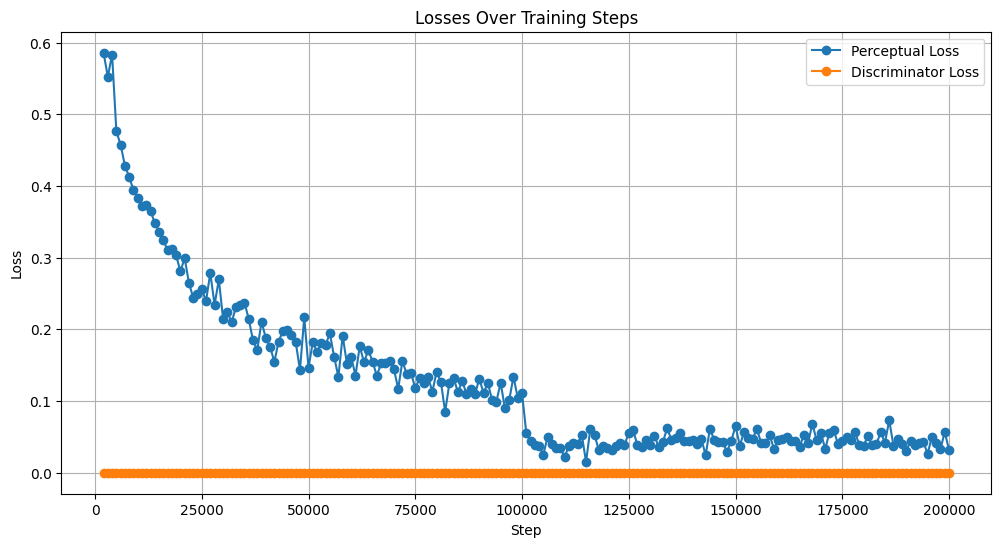

In [ ]:
import matplotlib.pyplot as plt

# Create a plot for losses
plt.figure(figsize=(12, 6))
plt.plot(step_losses, perceptual_losses, label='Perceptual Loss', linestyle='-', marker='o')
plt.plot(step_losses, discriminator_losses, label='Discriminator Loss', linestyle='-', marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Losses Over Training Steps')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/SRGAN/Results/output/losses_plot.png')
plt.show()



In [ ]:
weights_directory = f"/content/drive/MyDrive/SRGAN/weights/srgan_{dataset_key}"
os.makedirs(weights_directory, exist_ok=True)
weights_file = f'{weights_directory}/generator.h5'
srgan_checkpoint.generator.save_weights(weights_file)